
# Evaluating Untrained LLM Performance on Time Series Forecasting

## Introduction

This notebook examines the zero-shot performance of the Qwen2.5-0.5B-Instruct model on predator-prey time series forecasting without any fine-tuning. As established by Gruver et al. (2023), large language models contain implicit capabilities for time series forecasting due to their pre-training on diverse numerical data. Before investing computational resources in fine-tuning, we need to establish a robust baseline of the model's inherent capabilities.

This baseline serves multiple purposes:

1. Establishes a performance floor for comparison with fine-tuned models
2. Reveals whether the LLMTIME preprocessing scheme is effective
3. Helps identify specific forecasting weaknesses to target during fine-tuning
4. Informs optimal hyperparameter choices for the subsequent LoRA adaptation

We'll measure performance using Mean Squared Error (MSE) and Mean Absolute Error (MAE) metrics across different context window lengths.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader


import pandas as pd
import gc
from tqdm import tqdm

import h5py
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), os.path.pardir, 'src')))
from get_flops import QwenFlopsCalculator
from get_data import LotkaVolterraDataset, DataMaster
from preprocessor import NumericalProcessor

print("loading model")
# models
def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer

model, tokenizer = load_qwen()
print("model Loaded")

# some nice function for GPU Training
def clear_memory():
    gc.collect()
    with torch.device('cuda'):
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# random seed
torch.manual_seed(42)
np.random.seed(42)

loading model


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


model Loaded




## Data Preparation

For efficient experimentation, we use the `DataMaster` class which handles:

- Loading the Lotka-Volterra predator-prey time series data
- Preprocessing numerical data using the LLMTIME scheme
- Creating appropriate train/validation/test splits
- Building PyTorch DataLoaders with configurable parameters

The `experiment_fraction=0.1` parameter allows us to work with a smaller subset of data (10%) for faster iteration during development. In our final evaluation, we can scale this up to use the complete dataset by setting it to 1.0.

The context length parameter controls how much historical data the model sees when making predictions. Varying this parameter helps us understand the model's sensitivity to context window size, which is important for both performance optimization and FLOPS budget management.

In [3]:
# %%
import os
# Load the data


# data folder:
DATA_FOLDER = os.path.join(os.path.dirname(__name__), '..', 'data')


with h5py.File(os.path.join(DATA_FOLDER, 'lotka_volterra_data.h5'), "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

# Here we are only using a small fraction of the data for the experiment
data_master = DataMaster(
    tokenizer, trajectories, test_size=0.1, val_size=0.1, experiment_fraction=1)

 ## Zero-Shot Forecasting Evaluation

 Now we evaluate the untrained Qwen2.5-0.5B model on predator-prey time series forecasting. The evaluation procedure:

 1. **Sequential Prediction**: We provide the model with initial context (e.g., 128 tokens) and let it autoregressively generate predictions

 2. **Termination Criteria**: The model generates tokens until either:
    - It produces a maximum of `semi_colon_max` semicolons (**indicating how many complete timestamps of (predator, prey) pairs we want to forecast**)

 3. **Metric Calculation**: We decode the generated tokens back to numerical values and compute:
    - Mean Squared Error (MSE): Measures average squared difference between predictions and ground truth
    - Mean Absolute Error (MAE): Measures average absolute difference
    - Time-indexed metrics: Track how errors evolve over sequential prediction steps

 We evaluate across multiple context window sizes (128, 512, 768) to understand how the amount of historical context affects forecasting accuracy. This gives us insights into the model's inherent temporal reasoning capabilities and memory limitations.

 All FLOPS usage is carefully tracked to ensure we stay within our computational budget of 10^17 FLOPS.

In [4]:
# %%

processor = data_master.processor

flops_logger = QwenFlopsCalculator()


Total_flops_used = []
Flops_counter = 0
model.eval()
model.to(device)


logged_metrics = {}

for context_length in (128, 512, 768):
    semi_colon_max = 6
    logged_metrics[f'MSE_{context_length}'] = []
    logged_metrics[f'MAE_{context_length}'] = []
    logged_metrics[f'MSE_{context_length}_per_time'] = []
    logged_metrics[f'MAE_{context_length}_per_time'] = []
    logged_metrics[f'CE_{context_length}_per_token'] = []


    train_loader, val_loader, test_loader = data_master.get_data(
        context_length=context_length, batch_size = 1, experiment=True, 
        target_eval_pairs = semi_colon_max - 1
    )

    loader = tqdm(test_loader, leave=False)

    for data in loader:

        input_ids = data['input_ids'].to(device)
        target = data['target'].to(device)

        # we allow the model infer until (reached 2 * target length) or the model predict the end token (semi-colon token -> 26)
        max_length = semi_colon_max * target.shape[1]
        original_length = input_ids.shape[1]

        semi_colon_count = 0

        per_step_ce = []

        with torch.no_grad():
            for _ in range(max_length):

                flops_logger.log_flops(batch_size = 1, seq_len=context_length, rank= 0, verbose= False, inference=True, description = "MSE Untrained Evaluation")
                
                # only use context length size of input_ids to predict the next token
                outputs = model(input_ids[:, -context_length:])
                next_token_logits = outputs.logits[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1)
                input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

                # get the CE loss
                loss = torch.nn.functional.cross_entropy(next_token_logits, target[:, input_ids.shape[1] - original_length - 1])
                per_step_ce.append(loss.item())

                if next_token == 26:
                    semi_colon_count += 1
                    if semi_colon_count == semi_colon_max:
                        break
        
        logged_metrics[f'CE_{context_length}_per_token'].append(per_step_ce)


        # convert to numpy
        input_ids = input_ids.squeeze().cpu().numpy()
        target = target.squeeze().cpu().numpy()

        # postprocess
        predicted_values = processor.decode_to_string(input_ids[original_length:])
        target_values = processor.decode_to_string(target)

        # for both get the first semi-colon and use any value after that
        predicted_values = predicted_values.split(";")[1:semi_colon_count]
        predicted_values = [pred_val.split(',') for pred_val in predicted_values]
        predicted_values = [[float(val) for val in pred_val] for pred_val in predicted_values]
        predicted_values = np.array(predicted_values, dtype=np.float32)
        predicted_values = predicted_values / processor.scaler
        
        target_values = target_values.split(";")[1:semi_colon_count]
        target_values = [tar_val.split(',') for tar_val in target_values]
        target_values = [[float(val) for val in tar_val] for tar_val in target_values]
        target_values = np.array(target_values, dtype=np.float32)
        target_values = target_values / processor.scaler


        mse = np.mean((predicted_values - target_values) ** 2)
        mae = np.mean(np.abs(predicted_values - target_values))

        mse_per_time = np.mean((predicted_values - target_values) ** 2, axis=1)
        mae_per_time = np.mean(np.abs(predicted_values - target_values), axis=1)

        logged_metrics[f'MSE_{context_length}_per_time'].append(mse_per_time)
        logged_metrics[f'MAE_{context_length}_per_time'].append(mae_per_time)

        logged_metrics[f'MSE_{context_length}'].append(mse)
        logged_metrics[f'MAE_{context_length}'].append(mae)

        loader.desc = f"MSE: {mse:.6f}, MAE: {mae:.6f}"


    
    flops_df = pd.read_csv(flops_logger.log_file)
    current_exp_flops = flops_df[flops_df['name'] == flops_logger.log_name]
    Total_flops_used.append(
        current_exp_flops.flops.sum() - Flops_counter
    )
    Flops_counter = current_exp_flops.flops.sum()


# pad the perstep CE to the same length
max_length = max(len(x) for x in logged_metrics[f'CE_128_per_token'])
for key in logged_metrics:
    if 'CE' in key:
        for i in range(len(logged_metrics[key])):
            logged_metrics[key][i] += [np.nan] * (max_length - len(logged_metrics[key][i]))

            
# print the Total_flops_used
for i, flops in enumerate(Total_flops_used):
    print(f"Total FLOPS used for context length {[128, 512, 768][i]}: {flops:.3e}, -- [{flops / 1e17 * 100:.3f} percent of budget]")

Created 3200 chunks from 800 sequences


Created 400 chunks from 100 sequences


Created 400 chunks from 100 sequences


Sanity check Val: 100%|██████████| 400/400 [00:00<00:00, 23355.54it/s]

Sanity check Test: 100%|██████████| 400/400 [00:00<00:00, 23348.06it/s]


Created 1604 chunks from 800 sequences


Created 200 chunks from 100 sequences


Created 200 chunks from 100 sequences


Sanity check Train: 100%|██████████| 1604/1604 [00:00<00:00, 23558.39it/s]

Sanity check Val: 100%|██████████| 200/200 [00:00<00:00, 23430.56it/s]

Sanity check Test: 100%|██████████| 200/200 [00:00<00:00, 23514.63it/s]


Created 804 chunks from 800 sequences


Created 100 chunks from 100 sequences


Created 100 chunks from 100 sequences


Sanity check Train: 100%|██████████| 804/804 [00:00<00:00, 23708.13it/s]

Sanity check Val: 100%|██████████| 100/100 [00:00<00:00, 21374.43it/s]

Sanity check Test: 100%|██████████| 100/100 [00:00<00:00, 21374.43it/s]
                                                                               

Total FLOPS used for context length 128: 3.506e+15, -- [3.506 percent of budget]
Total FLOPS used for context length 512: 7.326e+15, -- [7.326 percent of budget]
Total FLOPS used for context length 768: 5.385e+15, -- [5.385 percent of budget]


Now, we can show the results of the evaluation. We will display the MSE and MAE for each context window size, as well as the time-indexed metrics to understand how the model's forecasting performance degrades over time.

Context Length: 128
MSE: 0.551002, MAE: 0.342673
MSE per time: [0.03231214 0.13250503 0.37468666 0.8040001  1.411504  ]
MAE per time: [0.09158203 0.19397523 0.32619426 0.47306427 0.6285472 ]

Context Length: 512
MSE: 0.104814, MAE: 0.150884
MSE per time: [0.00767334 0.02833716 0.07586795 0.14912029 0.2630726 ]
MAE per time: [0.04772122 0.08936435 0.14351271 0.20164469 0.27217925]

Context Length: 768
MSE: 0.069979, MAE: 0.116683
MSE per time: [0.00507598 0.01961915 0.0449815  0.09535234 0.18486528]
MAE per time: [0.03351163 0.06817318 0.10866642 0.15815355 0.21490975]



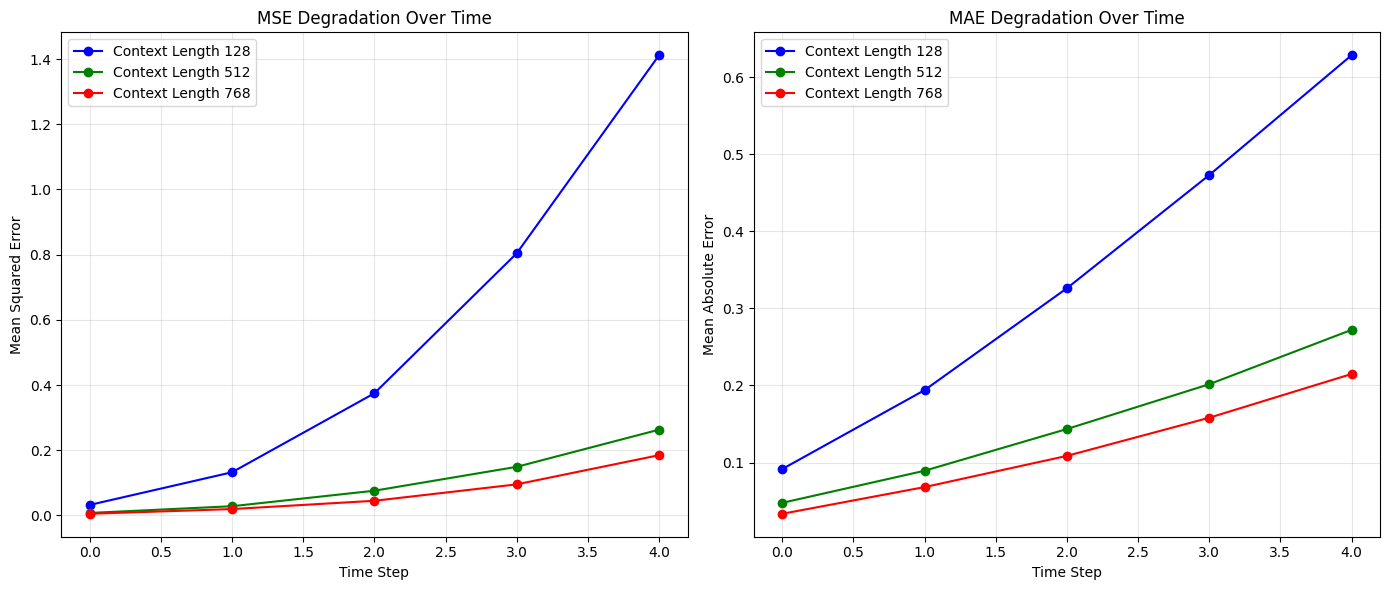

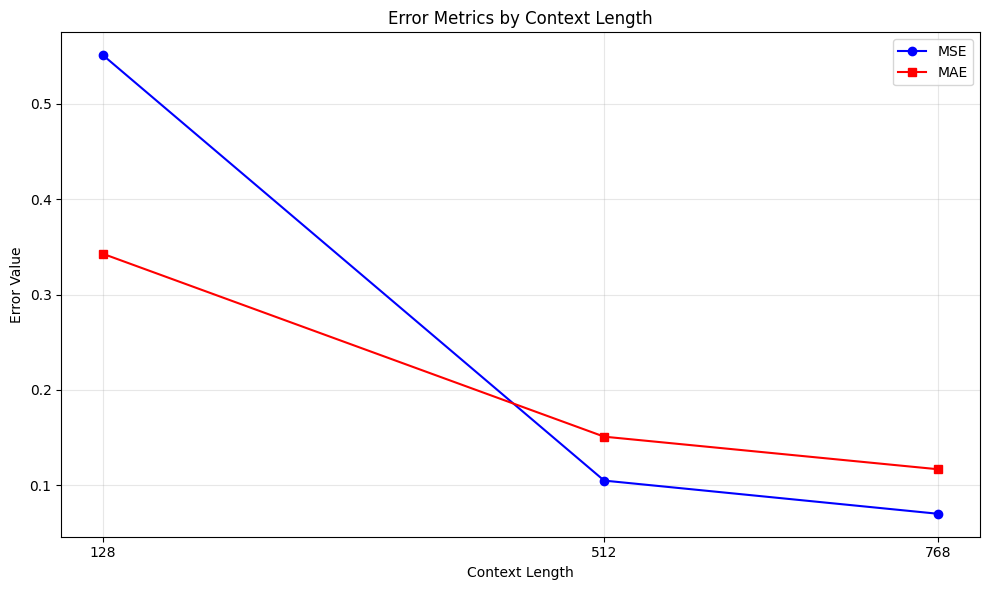

In [5]:
for context_length in (128, 512, 768):   
    print("=" * 50)
    print(f"Context Length: {context_length}")
    # print(f'CE per token: {np.mean(logged_metrics[f"CE_{context_length}_per_token"])}')
    print(f'MSE: {np.mean(logged_metrics[f"MSE_{context_length}_per_time"]):.6f}, MAE: {np.mean(logged_metrics[f"MAE_{context_length}_per_time"]):.6f}')
   
    print(f'MSE per time: {np.mean(logged_metrics[f"MSE_{context_length}_per_time"], axis=0)}')
    print(f'MAE per time: {np.mean(logged_metrics[f"MAE_{context_length}_per_time"], axis=0)}')

    print()


# Plot 1: MSE and MAE degradation over time for each context length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

context_lengths = [128, 512, 768]
colors = ['blue', 'green', 'red']
time_steps = range(5)  # 0 to 4 time steps

# Plot MSE degradation over time
for i, context_length in enumerate(context_lengths):
    mse_values = np.mean(logged_metrics[f'MSE_{context_length}_per_time'], axis=0)
    ax1.plot(time_steps, mse_values, marker='o', color=colors[i], label=f'Context Length {context_length}')

ax1.set_title('MSE Degradation Over Time')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Mean Squared Error')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MAE degradation over time
for i, context_length in enumerate(context_lengths):
    mae_values = np.mean(logged_metrics[f'MAE_{context_length}_per_time'], axis=0)
    ax2.plot(time_steps, mae_values, marker='o', color=colors[i], label=f'Context Length {context_length}')

ax2.set_title('MAE Degradation Over Time')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: MSE and MAE vs context length
fig, ax = plt.subplots(figsize=(10, 6))

mse_by_context = [np.mean(np.mean(logged_metrics[f'MSE_{cl}_per_time'], axis=0)) for cl in context_lengths]
mae_by_context = [np.mean(np.mean(logged_metrics[f'MAE_{cl}_per_time'], axis=0)) for cl in context_lengths]

ax.plot(context_lengths, mse_by_context, marker='o', color='blue', label='MSE')
ax.plot(context_lengths, mae_by_context, marker='s', color='red', label='MAE')

ax.set_title('Error Metrics by Context Length')
ax.set_xlabel('Context Length')
ax.set_ylabel('Error Value')
ax.set_xticks(context_lengths)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




Here, we can see a clear trend: as the **context window size increases, the model's forecasting performance improves**. This is expected, as the model has more historical data to base its predictions on. However, the improvement is not linear, indicating that the model may struggle with long-range dependencies or memory limitations. This information will be crucial for fine-tuning the model and optimizing its performance on this task.

Also, **as the model generates predictions further into the future, the forecasting error increases**. This is expected, as the model is making predictions based on its own generated outputs, which may introduce compounding errors. This trend is important to consider when designing forecasting systems that rely on autoregressive models.

Finally, for the cross-entropy loss, **we can see that there is a interesting zig-zag pattern**. Notice that the loss sometimes reaches zero, and then jumps back up. **The zero is due to the fact that the model have learnt that after a few steps, there must be a semicolon, and then the pattern repeats**. The semi-colon, the comma and the period are quite predictable tokens, and the model can learn to generalize them quite well. However, for the numerical values, the model struggles more, and the loss increases as the model tries to predict into the future.

When we apply a moving average of 10 steps to the loss, we can see that the zig-zag pattern is smoothed out, and we can see a more clear trend of the loss increasing over time. This is a common technique to visualize trends in noisy data, and can help us understand the overall performance of the model better. We can additionally see that again the model performs better with a larger context window, as it has more information to base its predictions on.

In [6]:
flops_df = pd.read_csv(flops_logger.log_file)
flops_used = flops_df[flops_df['name'] == flops_logger.log_name].flops.sum()
print(f"FLOPS used: {flops_used:.0f} or 1e{np.log10(flops_used):.2f}. Using {flops_used / 1e17 * 100:.2f}% of the Budget")

FLOPS used: 16216687344171552 or 1e16.21. Using 16.22% of the Budget


# Flops Analysis

Our analysis shows that even using only 1% of the data (10 % of the evaluation set, where the evaluation set is 10% of the entire dataset) already consumes 1.3% of the total computational budget, meaning each validation experiment costs approximately 0.4% of our budget. Since validation will be run multiple times in an experiment, and we have at least 12 experiments planned (3 [rank search] × 3 [learning rate search] + 3 [context length search]), this approach to validation is computationally expensive.

Therefore, I propose reducing the forecast horizon from 5 to 3 timestamps. This modification will decrease FLOPS usage by approximately 40%, making our experiments significantly more efficient.

This decision is supported by our observations: for the first 2 timestamps, MSE and MAE are relatively similar across different context lengths. However, as error propagates, the third timestamp is where performance between models begins to meaningfully diverge. The plots above demonstrate a clear difference in MSE and MAE values at the third timestamp, making it a suitable evaluation point while conserving computational resources.

Below, we show the updated results for the 3-timestamp forecast horizon. 

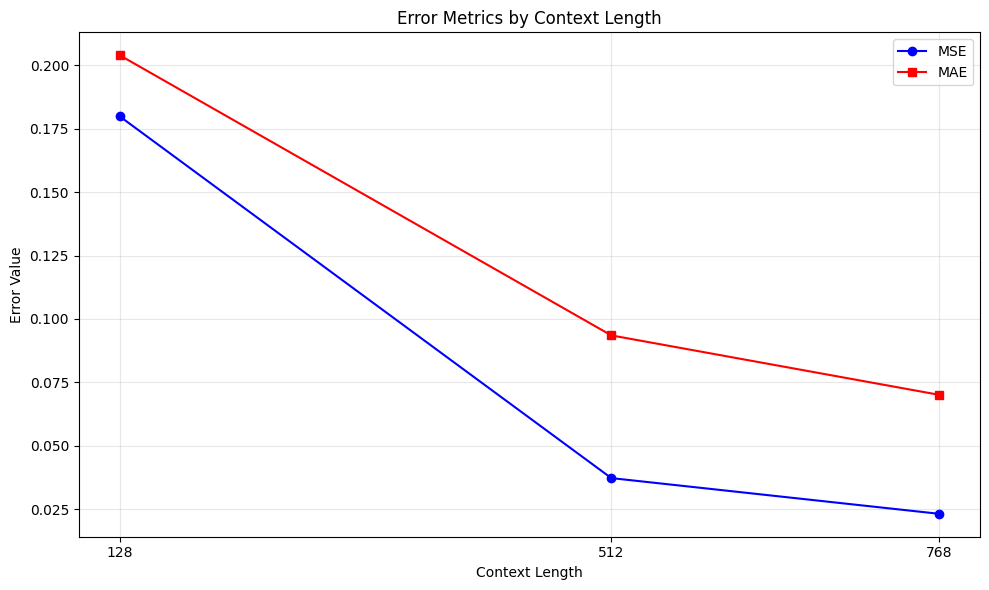

Context Length: 128, MSE: 0.180, MAE: 0.204
Context Length: 512, MSE: 0.037, MAE: 0.094
Context Length: 768, MSE: 0.023, MAE: 0.070


In [7]:
# Plot 2: MSE and MAE vs context length
fig, ax = plt.subplots(figsize=(10, 6))

mse_by_context = [np.mean(np.array(logged_metrics[f'MSE_{cl}_per_time'])[:, :3]) for cl in context_lengths]
mae_by_context = [np.mean(np.array(logged_metrics[f'MAE_{cl}_per_time'])[:, :3]) for cl in context_lengths]

ax.plot(context_lengths, mse_by_context, marker='o', color='blue', label='MSE')
ax.plot(context_lengths, mae_by_context, marker='s', color='red', label='MAE')

ax.set_title('Error Metrics by Context Length')
ax.set_xlabel('Context Length')
ax.set_ylabel('Error Value')
ax.set_xticks(context_lengths)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for context_length in (128, 512, 768):   
    print("=" * 50)
    print(f"Context Length: {context_length}", end=", ")
    print(
        f'MSE: {np.mean(np.mean(logged_metrics[f"MSE_{context_length}_per_time"], axis=0)[:3]):.3f}', end=", ")
    print(
        f'MAE: {np.mean(np.mean(logged_metrics[f"MAE_{context_length}_per_time"], axis=0)[:3]):.3f}')
    


## Results Analysis

The metrics above reveal how accurately the untrained Qwen2.5-0.5B model can forecast predator-prey dynamics. Several observations:

1. **Context Length Impact**: We can see how prediction accuracy varies with different context window sizes.

2. **Error Progression**: The per-timestep metrics show how errors accumulate (or potentially stabilize) as the model predicts further into the future.

3. **Overall Performance**: The aggregate MSE and MAE values establish our baseline performance, which we'll aim to improve through LoRA fine-tuning.

4. **FLOPS Accounting**: We've carefully tracked all computational costs to ensure our experiments remain within budget constraints.

These baseline results inform our fine-tuning strategy by highlighting:
- The optimal context window size for balancing performance and computational efficiency
- The model's inherent limitations on temporal forecasting
- Specific patterns where the model struggles most (which may require dedicated attention during fine-tuning)

In [10]:
datas = {}

predicted = {}

semi_colon_max = 20
for context_length in (128, 512, 768):
    train_loader, val_loader, test_loader = data_master.get_data(
        context_length=context_length, batch_size = 1, experiment=True, 
        target_eval_pairs = semi_colon_max - 1
    )
    temp_test_loader_active = iter(test_loader)
    datas[context_length] = [next(temp_test_loader_active)]
    datas[context_length].append(next(temp_test_loader_active))



processor = data_master.processor

flops_logger = QwenFlopsCalculator()


Total_flops_used = []
Flops_counter = 0
model.eval()
model.to(device)

result = {}



for context_length in (128, 512, 768):
    result[context_length] = []
    train_loader, val_loader, test_loader = data_master.get_data(
        context_length=context_length, batch_size = 1, experiment=True, 
        target_eval_pairs = semi_colon_max - 1
    )
    # claer tqdm instance
    tqdm._instances.clear()

    for data in datas[context_length]:

        input_ids = data['input_ids'].to(device)
        target = data['target'].to(device)

        # we allow the model infer until (reached 2 * target length) or the model predict the end token (semi-colon token -> 26)
        max_length = semi_colon_max * target.shape[1]
        original_length = input_ids.shape[1]

        semi_colon_count = 0

        per_step_ce = []

        with torch.no_grad():
            for _ in range(max_length):

                flops_logger.log_flops(batch_size = 1, seq_len=context_length, rank= 0, verbose= False, inference=True, description = "MSE Untrained Evaluation")
                
                # only use context length size of input_ids to predict the next token
                outputs = model(input_ids[:, -context_length:])
                next_token_logits = outputs.logits[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1)
                input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

                # get the CE loss
                loss = torch.nn.functional.cross_entropy(next_token_logits, target[:, input_ids.shape[1] - original_length - 1])
                per_step_ce.append(loss.item())

                if next_token == 26:
                    semi_colon_count += 1
                    if semi_colon_count == semi_colon_max:
                        break

        result[context_length].append(input_ids[:, original_length:].squeeze().cpu().numpy())

    
    flops_df = pd.read_csv(flops_logger.log_file)
    current_exp_flops = flops_df[flops_df['name'] == flops_logger.log_name]
    Total_flops_used.append(
        current_exp_flops.flops.sum() - Flops_counter
    )
    Flops_counter = current_exp_flops.flops.sum()


# print the Total_flops_used
for i, flops in enumerate(Total_flops_used):
    print(f"Total FLOPS used for context length {[128, 512, 768][i]}: {flops:.3e}, -- [{flops / 1e17 * 100:.3f} percent of budget]")

Created 3200 chunks from 800 sequences


Created 300 chunks from 100 sequences


Created 300 chunks from 100 sequences


Sanity check Val: 100%|██████████| 300/300 [00:00<00:00, 23829.02it/s]

Sanity check Test: 100%|██████████| 300/300 [00:00<00:00, 23666.33it/s]


Created 1604 chunks from 800 sequences


Created 200 chunks from 100 sequences


Created 200 chunks from 100 sequences


Sanity check Train: 100%|██████████| 1604/1604 [00:00<00:00, 23312.43it/s]

Sanity check Val: 100%|██████████| 200/200 [00:00<00:00, 22628.49it/s]

Sanity check Test: 100%|██████████| 200/200 [00:00<00:00, 22891.55it/s]


Created 804 chunks from 800 sequences


Created 100 chunks from 100 sequences


Created 100 chunks from 100 sequences


Sanity check Train: 100%|██████████| 804/804 [00:00<00:00, 23333.77it/s]

Sanity check Val: 100%|██████████| 100/100 [00:00<00:00, 20957.90it/s]

Sanity check Test: 100%|██████████| 100/100 [00:00<00:00, 20864.07it/s]


Created 3200 chunks from 800 sequences


Created 300 chunks from 100 sequences


Created 300 chunks from 100 sequences


Sanity check Val: 100%|██████████| 300/300 [00:00<00:00, 24143.58it/s]

Sanity check Test: 100%|██████████| 300/300 [00:00<00:00, 24139.42it/s]


Created 1604 chunks from 800 sequences


Created 200 chunks from 100 sequences


Created 200 chunks from 100 sequences


Sanity check Train: 100%|██████████| 1604/1604 [00:00<00:00, 24020.42it/s]

Sanity check Val: 100%|██████████| 200/200 [00:00<00:00, 23627.88it/s]

Sanity check Test: 100%|██████████| 200/200 [00:00<00:00, 23936.68it/s]


Created 804 chunks from 800 sequences


Created 100 chunks from 100 sequences


Created 100 chunks from 100 sequences


Sanity check Train: 100%|██████████| 804/804 [00:00<00:00, 23316.35it/s]

Sanity check Val: 100%|██████████| 100/100 [00:00<00:00, 21767.11it/s]

Sanity check Test: 100%|██████████| 100/100 [00:00<00:00, 21372.25it/s]


Total FLOPS used for context length 128: 6.547e+13, -- [0.065 percent of budget]
Total FLOPS used for context length 512: 2.596e+14, -- [0.260 percent of budget]
Total FLOPS used for context length 768: 3.967e+14, -- [0.397 percent of budget]


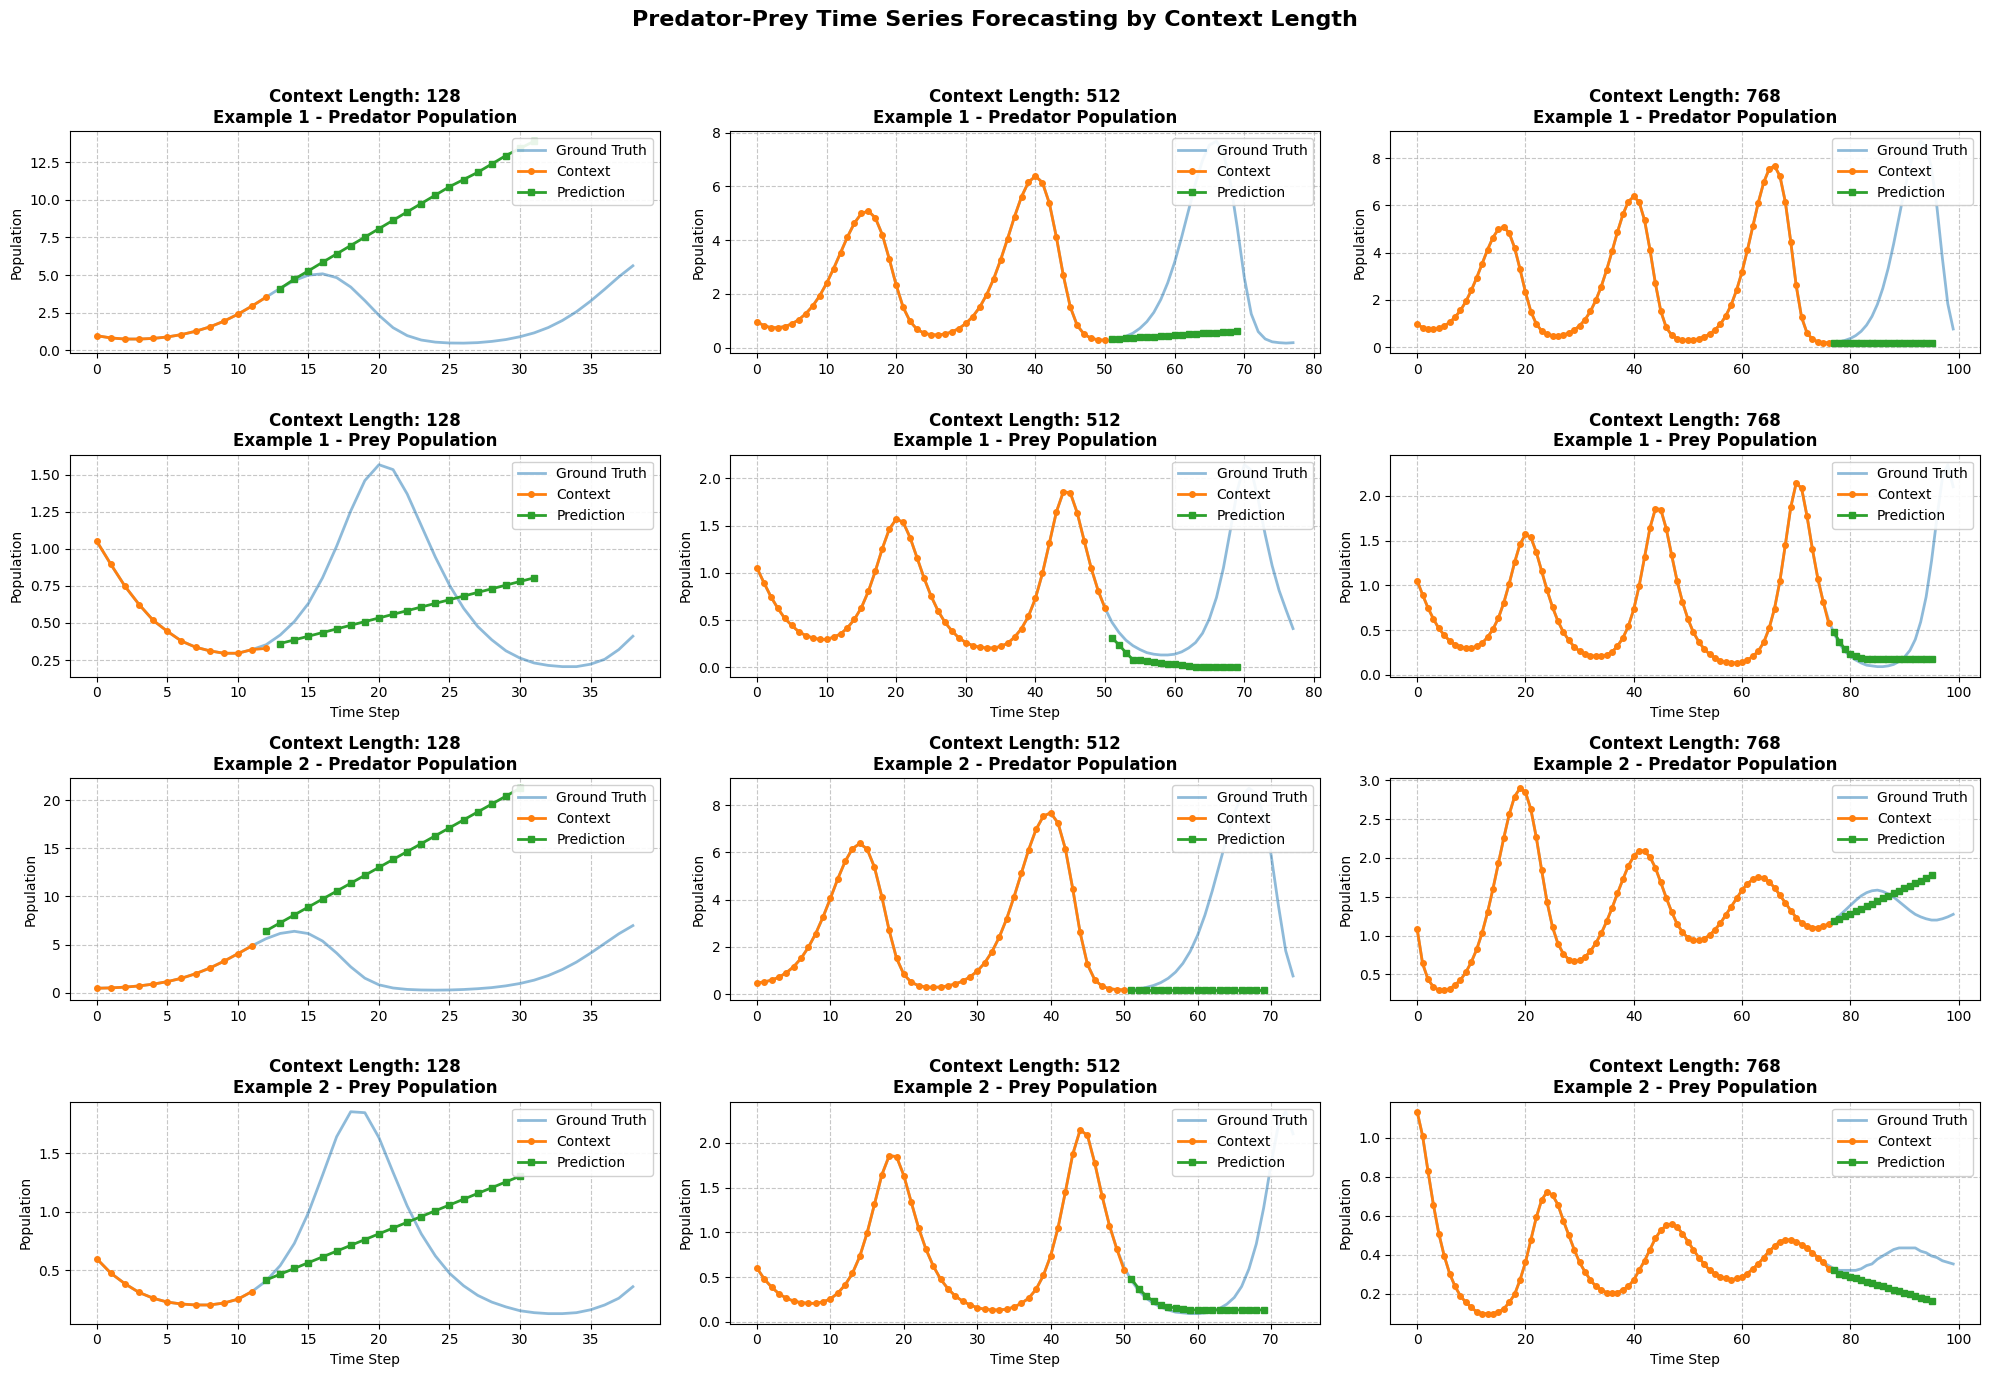

In [ ]:
# for each 
fig, ax = plt.subplots(4, 3, figsize=(20, 14))
context_lengths = [128, 512, 768]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
examples = ["Example 1", "Example 2"]

for i, context_length in enumerate(context_lengths):
    data = datas[context_length]
    
    for j, d in enumerate(data):
        input_ids = d['input_ids'].squeeze().cpu().numpy()
        target = d['target'].squeeze().cpu().numpy()

        full_sequence = np.concatenate([input_ids, target], axis=0)
        
        # Process data for plotting
        full_sequence_values = processor.postprocess(full_sequence)
        input_ids_values = processor.postprocess(input_ids)
        result_ids_values = processor.decode_to_string(result[context_length][j])
        # Split by semicolons and process each pair
        result_ids_values = result_ids_values.split(";")[1:semi_colon_count]
        result_ids_values = [pair.split(',') for pair in result_ids_values]
        result_ids_values = [[float(val) for val in pair] for pair in result_ids_values]
        result_ids_values = np.array(result_ids_values, dtype=np.float32)
        # Apply scaling factor to get actual values
        result_ids_values = result_ids_values / processor.scaler      # decode the values
        result_time = range(len(input_ids_values), len(result_ids_values) + len(input_ids_values))
        
        # Plot predator population
        ax[j*2, i].plot(full_sequence_values[:, 0], linewidth=2, color=colors[0], alpha=0.5, label='Ground Truth')
        ax[j*2, i].plot(input_ids_values[:, 0], linewidth=2, marker='o', markersize=4, label='Context', color=colors[1])
        ax[j*2, i].plot(result_time, result_ids_values[:, 0], linewidth=2, marker='s', markersize=5, 
                        label='Prediction', color=colors[2])
        
        # Plot prey population
        ax[j*2+1, i].plot(full_sequence_values[:, 1], linewidth=2, color=colors[0], alpha=0.5, label='Ground Truth')
        ax[j*2+1, i].plot(input_ids_values[:, 1], linewidth=2, marker='o', markersize=4, label='Context', color=colors[1])
        ax[j*2+1, i].plot(result_time, result_ids_values[:, 1], linewidth=2, marker='s', markersize=5, 
                          label='Prediction', color=colors[2])
        
        # Set titles and labels
        ax[j*2, i].set_title(f"Context Length: {context_length}\n{examples[j]} - Predator Population", fontsize=12, fontweight='bold')
        ax[j*2+1, i].set_title(f"Context Length: {context_length}\n{examples[j]} - Prey Population", fontsize=12, fontweight='bold')
        
        # Add grid and legend to make the plots more readable
        for row in [j*2, j*2+1]:
            ax[row, i].grid(True, linestyle='--', alpha=0.7)
            ax[row, i].legend(loc='upper right', frameon=True, framealpha=0.9)
            ax[row, i].set_ylabel('Population', fontsize=10)
            
            # Only show x label on bottom row
            if row == j*2+1:
                ax[row, i].set_xlabel('Time Step', fontsize=10)

# Add overall title
plt.suptitle('Predator-Prey Time Series Forecasting by Context Length', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# Potential Catastrophic Forgetting

Fine-tuning can often lead to catastrophic forgetting, where a model loses previously acquired knowledge. To assess whether this occurs, we evaluate the model's performance on a small set of prompts unrelated to time series forecasting. This allows us to gauge whether the model retains its general knowledge after fine-tuning. Although the prompt set is limited in size, it serves as an initial indicator of the model's performance. If signs of catastrophic forgetting are observed, they can be readily identified, and a larger, more comprehensive prompt set can be considered for future evaluations.

In [19]:
prompt_list = [
    "How many r in strawberry?",
    "what is the result of 1 + 1",
    "what is the result of 0.12 + 3.24",
    "0, 1, 1, 2, 3, 5, 8,",
    "Write a poem that uses numbers as metaphors. For instance, start with '1.20, 1.31; 0.93, 0.98' and explore what these figures might mean in life.",
    "Craft a poem that tells a story of dreams and memories, using punctuation naturally to evoke a rhythmic, lyrical quality."
]

for prompt in prompt_list:
    # Tokenize the prompt directly
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    # Generate text
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=512
    )
    
    # Extract only the newly generated tokens
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the generated tokens
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    print(f"""
=========================
Prompt: {prompt}
---
Response: {response}
=========================
    """)



Prompt: How many r in strawberry?
---
Response:  - Answers\nMath and Arithmetic\nNumbers\nWhat number of r's is there in strawberry?\nWiki User\n∙ 2013-04-08 16:57:59\nSee Answer\nBest Answer\nCopy\nThere are 15 red strawberries in a box.\nWiki User\n∙ 2013-04-08 16:57:59\nThis answer is:\nHelpful To Know\nHow many r's are in a box of strawberry?\n15\nOne box has 15 strawberries.\nOne pack of strawberries contains 24 strawberries.\nHow many strawberries does one person have to eat before they get full?\nIf you ate 15 strawberries, that would be your limit.\nIf you ate 16 strawberries, then you could eat another 1 or 2.\nIf you ate 17 strawberries, then you could eat another 2 or 3.\nAnd so on. You just keep eating until you reach your limit.\nFor example, if you had 15 strawberries, you could only eat 1 or 2.\nBut if you had 16 strawberries, you could eat 1 or 2 more,\nor 2 or 3 more, or 3 or 4 more, or 4 or 5 more...\nSo the answer is that you can't eat all 15 strawberries without\nh

# Tokenization Padding Methods
Here we showcase the impact of different padding methods on the model's performance. We compare the following padding strategies:
- **Left Padding**: The input sequence is padded on the left side, pushing the original sequence to the right.
- **Right Padding**: The input sequence is padded on the right side, keeping the original sequence at the beginning.
- **No Padding**: The input sequence is not padded, and the model processes it as is.


In [45]:
chunk = torch.cat(
                    [
                        datas[128][0]['input_ids'].squeeze(),
                        torch.full((384, ), tokenizer.pad_token_id),
                    ]
                )
print(chunk[:20])
# chunk = chunk.unsqueeze(-1).to(model.device)

# Reshape to [1, sequence_length] for batch dimension
input_ids = chunk.unsqueeze(0).to(device)
original_length = input_ids.shape[1]

# Generate tokens with a for loop
max_new_tokens = 100
model.eval()

with torch.no_grad():
    for _ in range(max_new_tokens):
        # Forward pass through the model
        outputs = model(input_ids[:, -768:])  # Use last 768 tokens as context if needed
        
        # Get logits for the last token and find the most likely next token
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        
        # Add the predicted token to our sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        
        # Optional: stop if we generate an EOS token
        if next_token.item() == tokenizer.eos_token_id:
            break

# Get only the newly generated part
generated_part = input_ids[0, original_length:].cpu().numpy()
print("\nGenerated token count:", len(generated_part))

# Decode and print the generated text
generated_text = tokenizer.decode(generated_part, skip_special_tokens=True)
print("\nGenerated text:")
print(generated_text)

tensor([16, 13, 16, 23, 11, 16, 13, 17, 23, 26, 16, 13, 15, 15, 11, 16, 13, 15,
        24, 26])

Generated token count: 100

Generated text:
Human can not only generate the correct answer but also ensure that the answer is correct. This is a very powerful tool for learning and improving. 

In addition to this, it is also important to understand the underlying principles of the problem and how to apply them to solve it. This requires a lot of practice and repetition, but it is also a valuable skill that can be used in many different situations. 

One of the most important things to remember when learning is to not just memorize the answer,


In [44]:
chunk = torch.cat(
                    [
                        torch.full((384, ), tokenizer.pad_token_id),
                        datas[128][0]['input_ids'].squeeze(),
                    ]
                )
print(chunk[:20])
# chunk = chunk.unsqueeze(-1).to(model.device)

# Reshape to [1, sequence_length] for batch dimension
input_ids = chunk.unsqueeze(0).to(device)
original_length = input_ids.shape[1]

# Generate tokens with a for loop
max_new_tokens = 100
model.eval()

with torch.no_grad():
    for _ in range(max_new_tokens):
        # Forward pass through the model
        outputs = model(input_ids[:, -768:])  # Use last 768 tokens as context if needed
        
        # Get logits for the last token and find the most likely next token
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        
        # Add the predicted token to our sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        
        # Optional: stop if we generate an EOS token
        if next_token.item() == tokenizer.eos_token_id:
            break

# Get only the newly generated part
generated_part = input_ids[0, original_length:].cpu().numpy()
print("\nGenerated token count:", len(generated_part))

# Decode and print the generated text
generated_text = tokenizer.decode(generated_part, skip_special_tokens=True)
print("\nGenerated text:")
print(generated_text)

tensor([151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
        151643, 151643])

Generated token count: 100

Generated text:
1;4.47,0.46;5.43,0.45;5.43;6.45,0.44;6.45;7.45,0.43;7.45;8.45,0.42;8.42;9.42,0.39;9.42;10.42,0.38;10


In [42]:
# Get the input tensor properly shaped
chunk = datas[128][0]['input_ids'].squeeze()
print("Original input length:", len(chunk))
print("First 20 tokens:", chunk[:20])

# Reshape to [1, sequence_length] for batch dimension
input_ids = chunk.unsqueeze(0).to(device)
original_length = input_ids.shape[1]

# Generate tokens with a for loop
max_new_tokens = 100
model.eval()

with torch.no_grad():
    for _ in range(max_new_tokens):
        # Forward pass through the model
        outputs = model(input_ids[:, -768:])  # Use last 768 tokens as context if needed
        
        # Get logits for the last token and find the most likely next token
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        
        # Add the predicted token to our sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        
        # Optional: stop if we generate an EOS token
        if next_token.item() == tokenizer.eos_token_id:
            break

# Get only the newly generated part
generated_part = input_ids[0, original_length:].cpu().numpy()
print("\nGenerated token count:", len(generated_part))

# Decode and print the generated text
generated_text = tokenizer.decode(generated_part, skip_special_tokens=True)
print("\nGenerated text:")
print(generated_text)

Original input length: 128
First 20 tokens: tensor([16, 13, 16, 23, 11, 16, 13, 17, 23, 26, 16, 13, 15, 15, 11, 16, 13, 15,
        24, 26])

Generated token count: 100

Generated text:
1;5.00,0.44;5.68,0.47;6.36,0.50;6.94,0.53;7.52,0.56;8.10,0.59;8.68,0.62;9.26,0.65;9.84,0.68;10.42,0.


The choice of padding method can significantly impact the model's performance. In particular, right padding resulted in the poorest performance, whereas left padding and no padding yielded comparable outcomes. This is likely because the model was trained using left padding, making it more compatible with that approach. However, no padding can also be effective, as it allows the model to process input sequences without introducing extraneous tokens.